# Анализ поведения пользователей мобильного приложения - Розов К.А.

**Область исследования:** в мобильном приложении по продаже продуктов питания необходимо провести анализ поведения пользователей.

**Цели анализа:**
 - изучить воронку продаж: узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. Выяснить на каких именно они застревают;
 - исследовать результаты A/A/B-эксперимента: дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. **Выяснить, какой шрифт лучше.**
 
**Предоставленные данные:**

*Файл: /datasets/logs_exp.csv* Каждая запись в логе — это действие пользователя, или событие.
 - EventName — название события;
 - DeviceIDHash — уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Ход исследования:**
 1. Обзор данных
 2. Предобработка данных
   - Изменение регистра и значений
   - Выделение столбца с датой
   - Работа с дубликатами
 3. Изучение и проверка данных
   - Количество событий, пользователей в логе
   - Изучение данных во времени
 4. Анализ воронки событий
   - Типы событий в логах, их частота
   - Доля пользователей на каждом шаге воронки
 5. Анализ результатов эксперимента
   - Количество пользователей в каждой экспериментальной группе
   - Проверка критериев успешного А/А (А/В)-теста
   - А/А-тест
   - А/В-тест
 6. Общие выводы


## Обзор данных

In [13]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import math as mth
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import datetime as dt
from scipy import stats as st
import numpy as np

In [14]:
 #открываем и сохраняем как датафрейм файл с данными:
try:
    df = pd.read_csv('logs_exp.csv', delimiter = "\t") # добавим разделитель для удобства прочтения данных
except:
    df = pd.read_csv('/datasets/logs_exp.csv', delimiter = "\t")

Изучим данные

In [15]:
display(df.head())#первые 5 строк датасета
display(df.info()) #основная информация о датасете
display('Число дубликатов:', df.duplicated().sum())# количество явных дубликатов
display('Количество пропусков', df.isna().sum()) #количество пропусков в датасете

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

'Число дубликатов:'

413

'Количество пропусков'

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Посмотрим на все уникальные значения столбцов EventName и ExpId

In [16]:
display(df.ExpId.unique())
display(df.EventName.unique())

array([246, 248, 247], dtype=int64)

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

**Наблюдения:**
 - В таблице представлены 244126 строк с логами действий пользователей в приложении; 
 - Отсутствуют пропуски;  
 - Присутствуют 413 дубликатов;
 - Названия колонок не соответствует единому стилю(нижний регистр);
 - Время события сохранено в секундах(timestamp) и столбец не соответствует типу временных данных;

## Предобработка данных

Выполним предобработку

In [17]:
# приведение столбцов к единому стилю
df = df.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp':'event_time', 'ExpId':'exp_id'})
# преобразование столбца к типу временных даннных
df.event_time = pd.to_datetime(df.event_time, unit='s')
# создание столбца с датой
df['event_date'] = df.event_time.dt.date
# удаление дубликатов 
df = df.drop_duplicates().reset_index(drop=True)

In [18]:
display(df.head())#первые 5 строк датасета
display(df.info()) #основная информация о датасете
display('Число дубликатов:', df.duplicated().sum())# количество явных дубликатов
display('Количество пропусков', df.isna().sum()) #количество пропусков в датасете

event_name       device_id_hash          event_time  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

   event_date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   device_id_hash  243713 non-null  int64         
 2   event_time      243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  int64         
 4   event_date      243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


None

'Число дубликатов:'

0

'Количество пропусков'

event_name        0
device_id_hash    0
event_time        0
exp_id            0
event_date        0
dtype: int64

**Выводы по разделу:**
 - после предобработки датафрейм состоит из 243713 логов с действиями пользователей;
 - были убраны 413 полных дубликатов;
 - наименования столбцов представлены в едином стандартном стиле;
 - столбец event_time имеет временной тип данных;
 - появился новый столбец с датой - event_date.

## Изучение и проверка данных

###  Анализ распределения событий по пользователям

Выведем на экран количество событий(после удаления полных дубликатов) и количество уникальных пользователей

In [19]:
display(f'Всего в логе осталось событий: {len(df)}')
display(f'Всего пользователей в логе: {len(df.device_id_hash.unique())}')
#display(f'В среднем на пользователя приходится {int(len(df) / len(df.device_id_hash.unique()))} события.')

'Всего в логе осталось событий: 243713'

'Всего пользователей в логе: 7551'

In [20]:
# определим сколько собитий приходиться на каждого пользователя
df.groupby('device_id_hash')[['event_name']].count().describe(percentiles=[0.75, 0.90, 0.95, 0.99])

event_name
count  7551.000000
mean     32.275593
std      65.154219
min       1.000000
50%      20.000000
75%      37.000000
90%      64.000000
95%      89.000000
99%     200.500000
max    2307.000000

Для наглядности построим график распределения событий по пользователям

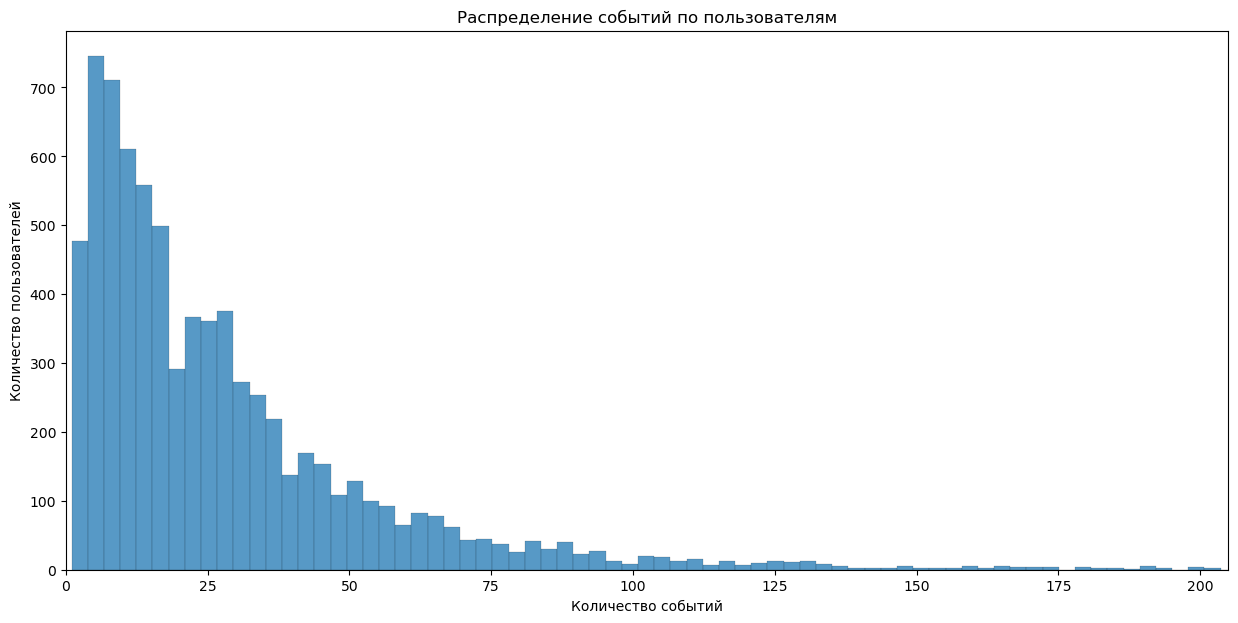

In [21]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df.groupby('device_id_hash')[['event_name']].count(), x='event_name')
plt.title('Распределение событий по пользователям')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.xlim(0,205)
plt.show()

**Наблюдения:**
 - В таблице после удаления дубликатов осталось 243713 строк с логами действий пользователей в приложении; 
 - Всего пользователей в логе: 7551;  
 - В среднем на пользователя приходится 32 события;
 - Медианное значения количества событий для одного пользователя равно 20;
 - Только 5 % пользователей совершили 89 событий и более;

### Анализ распределения событий по времени

Начнем с определения минимальной и максимальной дат, представленных в датафрейме

In [22]:
display('Минимальная дата в журнале:', df.event_time.min())
display('Максимальная дата в журнале:', df.event_time.max())

'Минимальная дата в журнале:'

Timestamp('2019-07-25 04:43:36')

'Максимальная дата в журнале:'

Timestamp('2019-08-07 21:15:17')

Данными представлены за период с 27 июля по 07 августа 2019 г. Построим график распределения данных во временной динамике

C:\Users\yd7298\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x700 with 0 Axes>

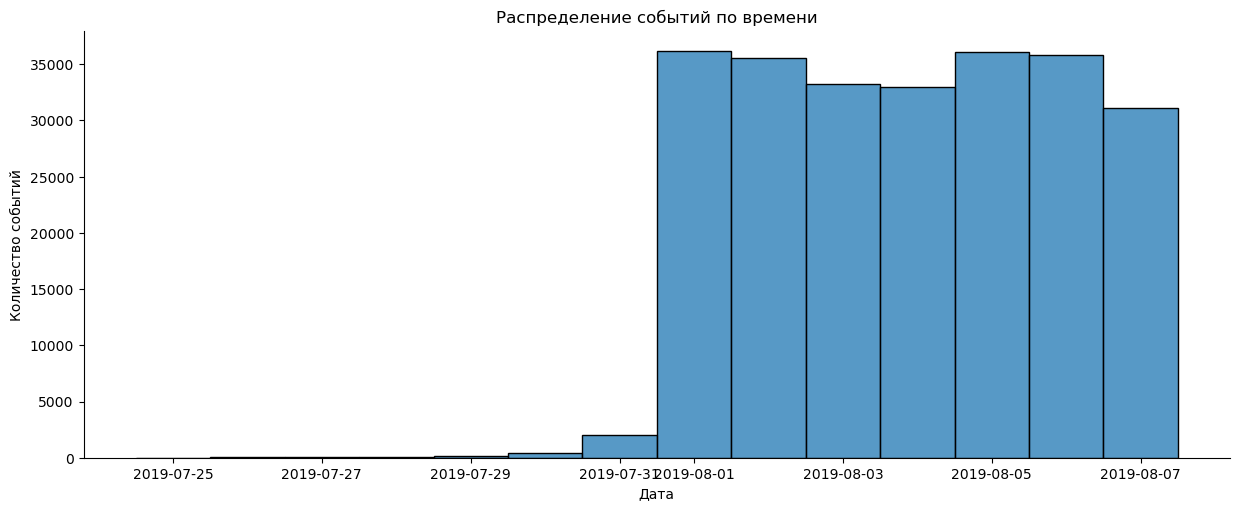

In [23]:
plt.figure(figsize=(15, 7))
sns.displot(data=df, x="event_date", height = 5,  aspect = 2.5)
plt.title('Распределение событий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

**Наблюдения:**
 - Из графика однозначно видно, что события по времени распределены неравномерно: с 1 августа произошел резкий скачек с 2 тыс до 36; 
 - Период до 1 августа можно считать нерепрезентативным для дальнейшего анализа(можно отфильтровать);  
 - Вероятно на резкое увеличение числа событий во вторую неделю повлияло какое-то рекламное событие;

Отфильтруем события для периода с 1 по 7 августа  и посмотрим процент оставшихся

In [26]:
df_filtered = df.query('event_date >= datetime(2019, 8, 1).date()')
display(df_filtered.info())

In [ ]:
display(f'Всего событий во второй неделе: {len(df_filtered)}')
display(f'Доля событий второй недели: {(len(df_filtered) / len(df)):.2%}')
display(f'Доля потерь событий второй недели: {1- (len(df_filtered) / len(df)):.2%}')
display(f'Всего пользователей во второй неделе: {len(df_filtered.device_id_hash.unique())}')
display(f'Доля пользователей на второй недели: {(len(df_filtered.device_id_hash.unique()) / len(df.device_id_hash.unique())):.2%}')
display(f'Доля потерь пользователей на второй недели: {1- (len(df_filtered.device_id_hash.unique()) / len(df.device_id_hash.unique())):.2%}')

Проверим все ли группы попадают в отфильтрованные данные

In [ ]:
df_filtered['exp_id'].unique()

**Наблюдения:**
 - После фильтрации в данных осталось 240887 событий и 7534 уникальных пользователей; 
 - Доля событий второй недели составляет 98.84%, потеряно чуть более 1% данных;
 - Все 3 группы попадают в отфильтрованные данные.

**Выводы по разделу:**
 - Распределение по события:
   - В таблице после удаления дубликатов осталось 243713 строк с логами действий пользователей в приложении; 
   - Всего пользователей в логе: 7551;  
   - В среднем на пользователя приходится 32 события;
   - Медианное значения количества событий для одного пользователя равно 20;
   - Только 5 % пользователей совершили 89 событий и более;
 - Распределение по времени:
   - Из графика однозначно видно, что события по времени распределены неравномерно: с 1 августа произошел резкий скачек с 2 тыс до 36; 
   - Период до 1 августа можно считать нерепрезентативным для дальнейшего анализа(можно отфильтровать);  
   - Вероятно на резкое увеличение числа событий во вторую неделю повлияло какое-то рекламное событие;
 - Фильтрация значений:
   - После фильтрации в данных осталось 240887 событий и 7534 уникальных пользователей; 
   - Доля событий второй недели составляет 98.84%, потеряно чуть более 1% данных;
   - Все 3 группы попадают в отфильтрованные данные.

## Анализ воронки событий

Для начала сгруппируем данные и найдем количество событий, уникальных пользователей на каждом уровне воронки, а также конверсию пользователей на каждом уровне относительно события "MainScreenAppear" и конверсию относительно предыдущего шага(воронку)

In [ ]:
# сгруппируем таблицу по событиям
df_funnel = df_filtered.groupby('event_name').agg({'event_name':'count','device_id_hash':'nunique'}).rename(columns={'event_name':'event_count', 'device_id_hash':'unique_device_count'})

# найдем долю уникальных пользователей относительно общего количества пользователей 
df_funnel['conversion'] = df_funnel['unique_device_count']/df_filtered['device_id_hash'].nunique()*100
# отсортируем сводную таблицу по убыванию количества уникальных пользователей
df_funnel = df_funnel.sort_values('unique_device_count', ascending=False).reset_index(drop=False)
# добавляем столбец со сдвигом на след шаг уникального количества
df_funnel['prev_step'] = df_funnel['unique_device_count'].shift() 
# вычисляем конверсию для следущего шага
df_funnel['funnel_conversion'] = df_funnel['unique_device_count'] / df_funnel['prev_step']*100 
# удаляем технический столбец prev_step(он нам не нужен)
df_funnel.drop(columns= ['prev_step'], axis = 1, inplace = True)
# выводим таблицу
display(df_funnel)

У нас имеются:
 - MainScreenAppear: просмотр главной страницы;
 - OffersScreenAppear: просмотр страницы предложений;
 - CartScreenAppear: просмотр корзины;
 - PaymentScreenSuccessful: переход на страницу успешной оплаты;
 - Tutorial - просмотр обучающей информации для новых пользователей.
 
**Наблюдения:**
 - Первые четыре события образуют последовательную цепочку движения пользователя по приложению;
 - Tutorial не является обязательным этапом
 

Построим график, отражающий долю уникальных пользователей  каждом уровне относительно события "MainScreenAppear". Tutorial не будем включать в визуализацию. так как это событие не является обязвательным в последовательности событий.

In [ ]:
plt.figure(figsize=(15, 7))
sns.barplot(data=df_funnel.loc[0:3], x='event_name', y='conversion')
plt.title('Движение пользователей в приложении')
plt.xlabel('Событие')
plt.ylabel('Доля пользователей')
plt.show()

In [ ]:
fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = df_funnel.loc[0:3]['event_name'],
    x = df_funnel.loc[0:3]['unique_device_count'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(title='Воронка событий по пользователям', title_x = 0.5)
fig.show()

**Выводы по разделу:**
 - Наиболее часто встречающееся событие- 'MainScreenAppear'. Его совершали 7419 пользователей из 7534 (уникальное количество пользователей после "чистки")
 - Из сводной таблицы видно:
   - Общий процент перешедших на следующий уровень действий от главного экрана к экрану предложения - 61.9%; 
   - Перешедших от экрана предложения к экрану корзины - 81.3%1;  
   - От экрана корзины к экрану успешного платежа- 94.8%;
 - Из графика видно:
   - Самый большая просадка посещаемости - между главной страницей и страницей предложений (каталогом) - почти 40% ; 
   - На следующих шагах отсеивается всего 19% и 5% пользователей соответветственно;  
   - Всего до успешной оплаты доходят 47% пользователей приложения.

## Анализ результатов эксперимента

### Количество пользователей в каждой экспериментальной группе

Для анализа результатов эксперимента следут брать отфильтрованные по дате события.

In [ ]:
df_group = df_filtered.groupby('exp_id')['device_id_hash'].nunique()
display(df_group)

Получены выборки размером 2484 пользователя в 246 группе, 2513 пользователей в 247 группе и 2537 пользователей в 248 группе.

In [ ]:
# сформируем сводную таблицу с количеством пользователей по каждому действию(без прохождения обучения)
pivot_exp = (
    df_filtered.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
    .sort_values(by=246, ascending=False)
              )
pivot_exp['246_247'] = pivot_exp[246] + pivot_exp[247]
pivot_exp

### Проверка критериев успешного А/А (А/В)-теста

**Необходимо проверить:**
 - Количество уникальных пользователей в различных группах различается не более, чем на 1-2%
 - Каждый уникальный пользователь попадает только в одну группу

In [ ]:
# сравним отношения количеств пользователей для групп
display(
    'Отличие размеров групп:',
     '246 от 247:', round(df_group[246]/df_group[247], 2),
     '246 от 248:', round(df_group[246]/df_group[248], 2),
     '247 от 248:', round(df_group[247]/df_group[248], 2),
    )

Различия между группами составляют не более 2 процентов

In [ ]:
# проверяем есть ли пользователи, попавшие не только в одну группу
df_filtered.groupby('device_id_hash')['exp_id'].nunique().reset_index()\
                                           .query('exp_id > 1').count()

Таких пользователей не оказалось

**Наблюдения:**
 - Различия между группами составляют не более 2 процентов; 
 - Каждый уникальный пользователь попадает только в одну группу;  
 - *Данные можно считать корректными для проведения анализов.*

### А/А-тест

Для А/А-эксперимента есть две контрольные группы. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 групп.

Для проведения теста сформулируем гипотезы:

 - Н0 : конверсии групп не отличаются
 - Н1 : конверсии групп отличаются

Применим для групп Z-тест на равенство долей.

Коэффициент статистической значимости примем равным 0.01.

Cоздадим функцию для проведения z-теста для проверки гипотезы о равенстве долей двух выборок, где:

exp_1, exp_2 - номера тестируемых групп,
alpha - критический уровень статистической значимости,
event - событие, на уровне которого мы проверяем равенство долей.

In [ ]:
#напишем функцию для статистической значимости

def z_test(df_exp, num_group, alpha):
    #пользователи в каждой группе
    users = [df_exp.query('exp_id == @group')['device_id_hash'].nunique() for group in num_group]
    #перебор экспериментальных групп по событиям и количество пользователей
    for event in df_exp.event_name.unique():
        events = [df_exp.query('exp_id == %d and event_name == "%s"' % (group, event))['device_id_hash'].nunique() for group in num_group]
        
        p1 = events[0] / users[0] 
        p2 = events[1] / users[1] 
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]))
        
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Событие:', event)
        print('p-значение: {p_value:}'.format(p_value=p_value))
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы')
            
        print('****************************************')  

In [ ]:
# выведем результаты эксперимента для A/A- теста
z_test(df_filtered.query('event_name != "Tutorial"'), [246, 247], 0.01)

**Наблюдения:**
 - Проведение 4 z-тестов контрольных групп 246 и 247 не выявило статистически достоверных отличий между между группами

### А/В-тест

Для А/B-эксперимента есть три пары контрольные группы. Проверим, находят ли статистические критерии разницу между парами групп 246 и 248, а также 247 и 248. И выполним сравнение различия статистических критериев между объединенной группой 246+247 и 248.

Для проведения теста гипотезы остануться аналогичными:

 - Н0 : конверсии групп не отличаются
 - Н1 : конверсии групп отличаются

Применим для групп Z-тест на равенство долей.

Коэффициент статистической значимости примем равным 0.01.

Выводим результаты теста для каждого события А/B-теста: сравнение групп 246 и 248

In [ ]:
# выведем результаты эксперимента для A/B- теста
z_test(df_filtered.query('event_name != "Tutorial"'), [246, 248], 0.01)

**Наблюдения:**
 - Различия между группами 246 и 248, также, статистически не значимы

Выводим результаты теста для каждого события А/B-теста: сравнение групп 247 и 248

In [ ]:
# выведем результаты эксперимента для A/B- теста
z_test(df_filtered.query('event_name != "Tutorial"'), [247, 248], 0.01)

**Наблюдения:**
 - Различия между группами 247 и 248, также, статистически не значимы

Сравним результаты экспериментальной группы 248 с объединённой контрольной группой, добавим 247 в 246 группу.
Для это выполним фукнцию копирования отфильрованного и заменим значения группы 246 на группу 247. Так мы объединим группы.

In [ ]:
df_un_group = df_filtered.copy()
df_un_group['exp_id'].replace({246: 247}, inplace=True)

In [ ]:
# выведем результаты эксперимента для A/B- теста
z_test(df_un_group.query('event_name != "Tutorial"'), [247, 248], 0.01)

**Наблюдения:**
 - Различия между объединенной группой и 248, также, статистически не значимы

Был выбран уровень значимости в 0.01. Всего было сделано 16 проверок статистических гипотез (12 из них проверяли разницу между контрольными группами и экспериментальной группой с изменённым шрифтом). Можно бы было воспользоваться методом Бонферрони для поправки значения p-value, в нашем случае его уменьшить следовало бы до 0.01/16=0.000625.

**Выводы по разделу:**
 - Получены выборки размером 2484 пользователя в 246 группе, 2513 пользователей в 247 группе и 2537 пользователей в 248 группе
 - Проверка критериев успешного А/А (А/В)-тестов:
   - Количество уникальных пользователей в различных группах различается не более, чем на 2%;
   - Каждый уникальный пользователь попадает только в одну группу;
 - Результаты А/А (А/В)-тестов:
   - Для каждых пар групп различия статистически не значимы
 - Для всех проведенных тестов, p-value был значительно больше 0.05, следовательно **изменение шрифта не повлияло на пользователей**

## Общие выводы

**Целями проекта** были:
 - изучить воронку продаж: узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. Выяснить на каких именно они застревают;
 - исследовать результаты A/A/B-эксперимента: дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 
 - **Выяснить, какой шрифт лучше.**
 
По результатам *обзора и подготовки данных* определено, что:
 - датафрейм состоит из 243713 логов с действиями пользователей;
 - имеются 413 полных дубликатов, которые были убраны;
 - наименования столбцов представлены в едином стандартном стиле;
 - столбец event_time имеет временной тип данных;
 - появился новый столбец с датой - event_date.
 
В результате анализа воронки выявлено: 
 - Наиболее часто встречающееся событие- 'MainScreenAppear'. Его совершали 7419 пользователей из 7534 (уникальное количество пользователей после "чистки")
 - Из сводной таблицы видно:
   - Общий процент перешедших на следующий уровень действий от главного экрана к экрану предложения - 61.9%; 
   - Перешедших от экрана предложения к экрану корзины - 81.3%1;  
   - От экрана корзины к экрану успешного платежа- 94.8%;
 - Из графика видно:
   - Самый большая просадка посещаемости - между главной страницей и страницей предложений (каталогом) - почти 40% ; 
   - На следующих шагах отсеивается всего 19% и 5% пользователей соответветственно;  
   - Всего до успешной оплаты доходят 47% пользователей приложения.
 
По ходе подготовки, проведения и анализа А/A/В-тестов были сделаны следующие выводы:
 - Получены выборки размером 2484 пользователя в 246 группе, 2513 пользователей в 247 группе и 2537 пользователей в 248 группе
 - Проверка критериев успешного А/А (А/В)-тестов:
   - Количество уникальных пользователей в различных группах различается не более, чем на 2%;
   - Каждый уникальный пользователь попадает только в одну группу;
 - Результаты А/А (А/В)-тестов:
   - Для каждых пар групп различия статистически не значимы
 - Для всех проведенных тестов, p-value был значительно больше 0.05, следовательно;
 - Выбор уровня значимости 0,01 не повлиял на результаты экперимента.

**Результаты:**
 - Гипотеза об отсутствии различий между конверсиями событий тестируемых групп не опровергнута.

Это означает, что **разницы между поведением пользователей до изменения шрифта приложения и после его изменения с большой долей вероятности нет. Можно оставить шрифт прежним.**